# Read before doing anything
We found an error in the training dataset 2 (there was a whitespace in front of each feature name). Therefore we preprocessed and fixed it. Our files have been renamed and they are as follows:
* ./data/trn_set_1.csv --> BATADAL_dataset03.csv
* ./data/trn_set_2.csv --> BATADAL_dataset04.csv
* ./data/test_set.csv --> BATADAL_test_dataset.csv

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import numpy as np
sns.set()

In [2]:
import warnings
# warnings.filterwarnings("ignore")

In [3]:
file_name = "trn_set_1"
DATA_PATH = r"C:../data/{}.csv".format(file_name)

data = pd.read_csv(DATA_PATH, header=0, parse_dates=['DATETIME'], index_col='DATETIME', dayfirst=True)
data.index = pd.DatetimeIndex(data.index.values, freq = data.index.inferred_freq)

First, we need to choose the signal we want to process and test whether they are stationary or not. 

The documentation of the competition highlights the importance of an ideal detection mechanism being able to identify which physical components of the network are being attacked. Considering this motivation, we decided to choose as three of the analyzed sensors for the ARMA model the water level in all towers ('L\_T1' to 'L\_T3'). Additionally, we also analyzed three flow signals, namely 'F\_PU1', 'F\_PU2' and 'F\_PU10'.

In [4]:
names = ['L_T1', 'L_T2', 'L_T3', 'F_PU1', 'L_T4', 'F_PU10']

In [ ]:
signals = {} # signals we want to model with ARMA
for name in names:
    series = pd.Series(data[name], data.index)
    signals[name] = series
    display(series.head(2))

Let's first do the analysis visually, by plotting them. We can observe that all of them have visually constant statistical properties (mean, variance, autocorrelation) over time, so they seem to be stationary. However, let's also perform a statistical test to make sure.



Processing signal 'L_T1'


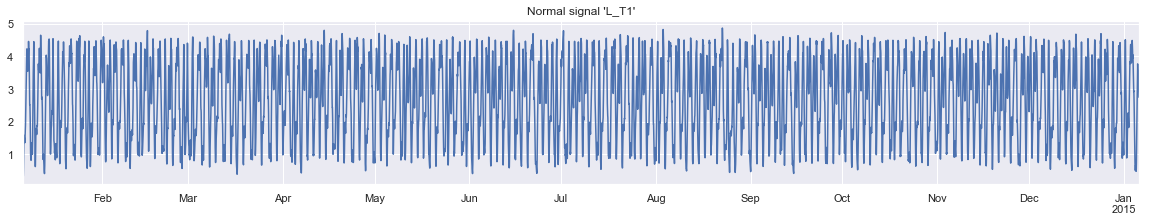



Processing signal 'L_T2'


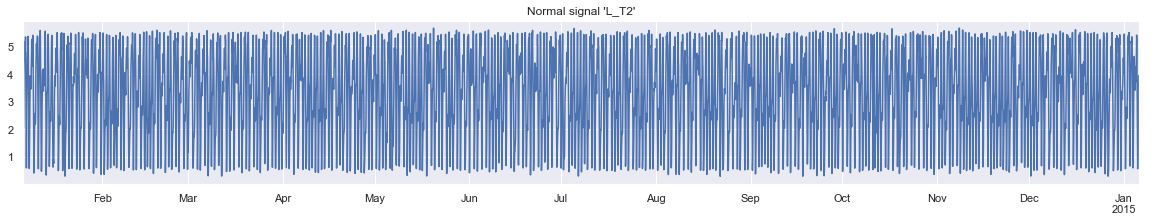



Processing signal 'L_T3'


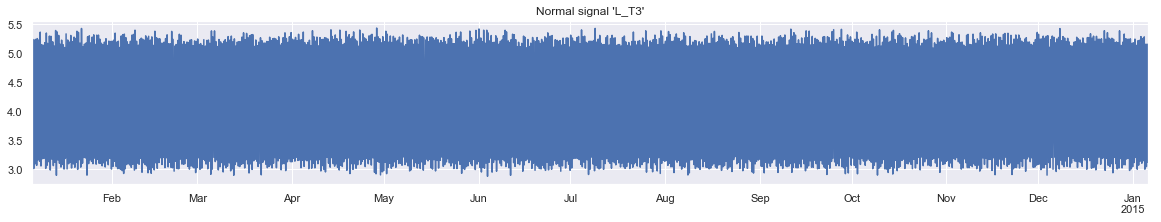



Processing signal 'F_PU1'


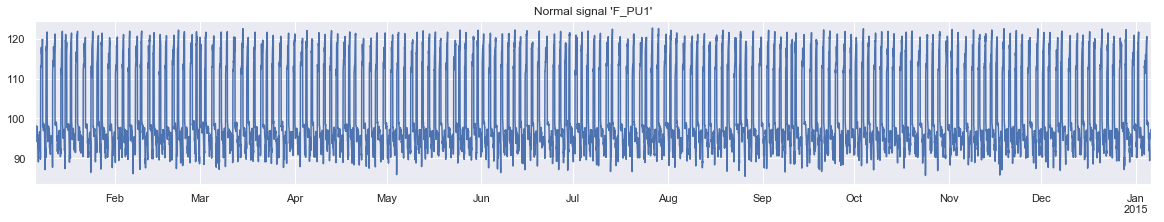



Processing signal 'L_T4'


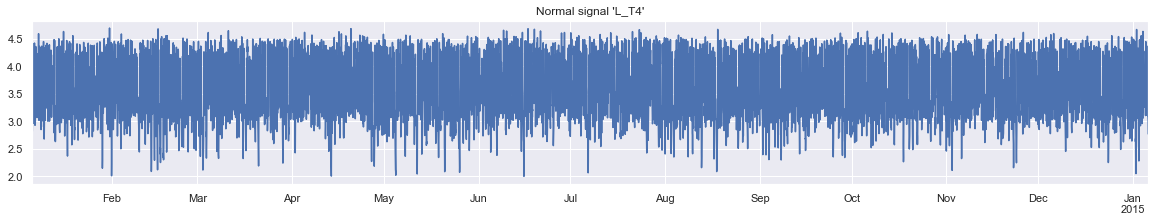



Processing signal 'F_PU10'


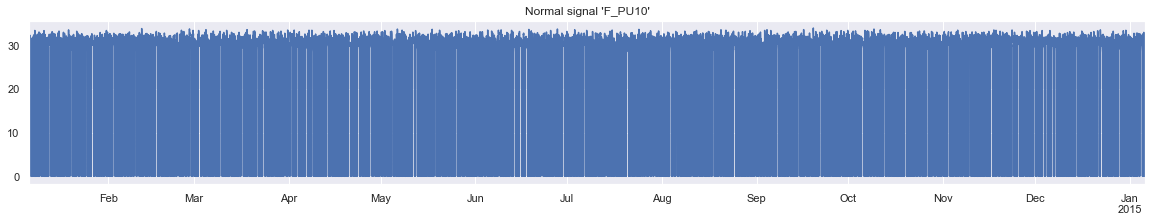

In [6]:
for signal in signals.keys():
    print(f"\n\nProcessing signal '{signal}'")
    
    series = signals[signal]
    
    # visualize it
    series.plot(figsize=(20,3))
    plt.title(f"Normal signal '{signal}'")
    plt.show()
    
    # do not uncomment. Differencing has been shown not necessary
    #stationary = difference(series)

    # visualize it
    #stationary.plot(figsize=(20,3))
    #plt.title(f"Stationary signal '{signal}'")
    #plt.show()
              
    #signals[signal] = stationary

Let's use the Augmented Dickey–Fuller test for testing stationarity stationarity. We will use a confidence level of 0.05.

For this test, the hypotheses are the following:
    - Null Hypothesis (H0): The time series has a unit-root and is non-stationary.
    - Alternative Hypothesis (H1): The time series does not have a unit-root and, thus, it is stationary.
    
If the p-values we obtain from the test are below our considered confidence level of 0.05, then we reject the Null Hypothesis, H0, meaning that our data is stationary.

Let's have a look at the results!

In [7]:
from statsmodels.tsa.stattools import adfuller


for signal in signals.keys():
    print(f"\n\nTesting stationarity for '{signal}'")
    
    result = adfuller(signals[signal])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))



Testing stationarity for 'L_T1'
ADF Statistic: -20.615633
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Testing stationarity for 'L_T2'
ADF Statistic: -18.612726
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Testing stationarity for 'L_T3'
ADF Statistic: -14.375782
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Testing stationarity for 'F_PU1'
ADF Statistic: -27.596471
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Testing stationarity for 'L_T4'
ADF Statistic: -16.582866
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Testing stationarity for 'F_PU10'
ADF Statistic: -16.463434
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


We can observe that all the p-value we obtain are significantly lower than 0.05 and, thus, all the considered signals are **stationary**. We can now proceed with the ARMA analysis.

### Plot ACF and PACF of the signal, to retrieve the values of p and q of the ARMA



Computing ACF and PACF for 'L_T1'


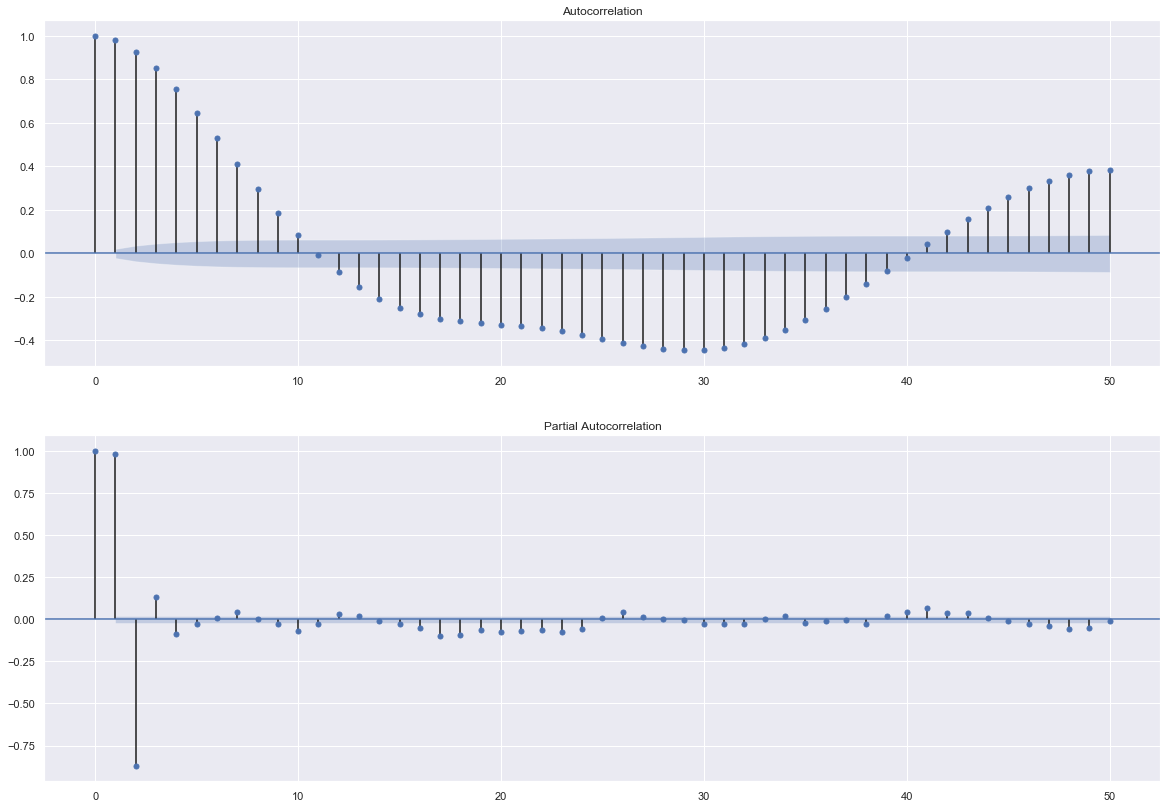



Computing ACF and PACF for 'L_T2'


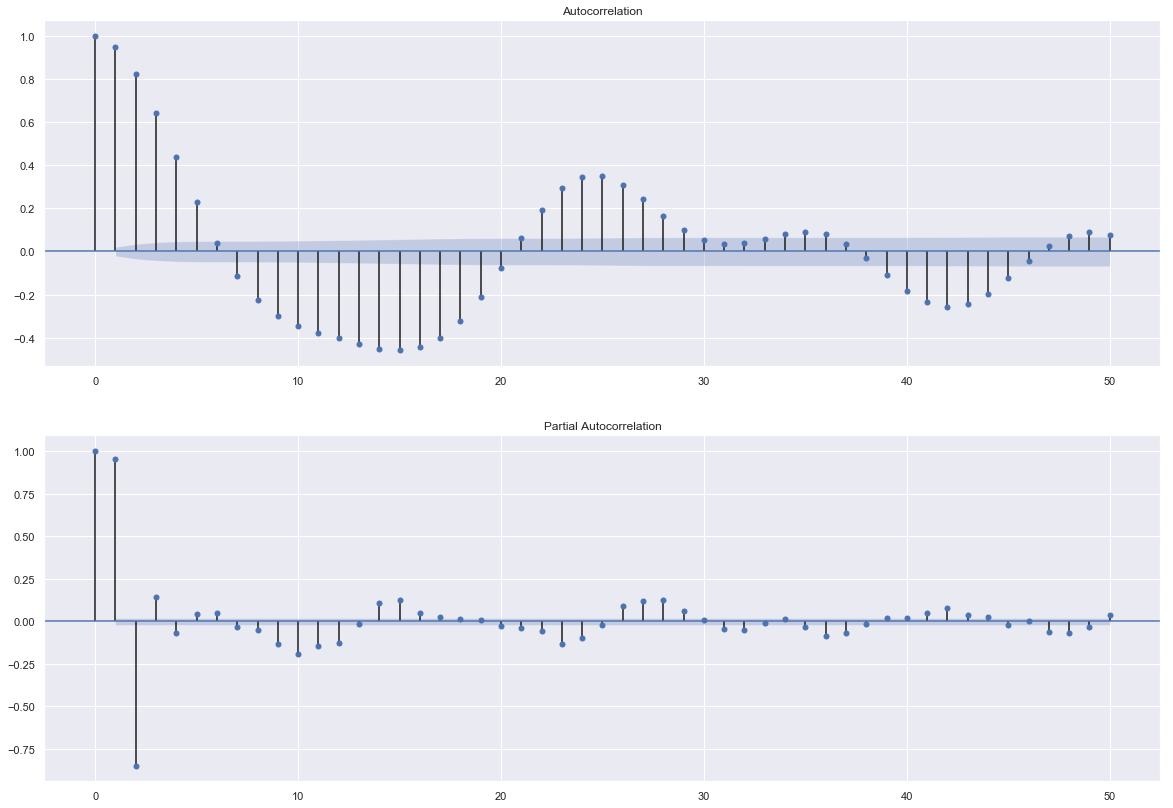



Computing ACF and PACF for 'L_T3'


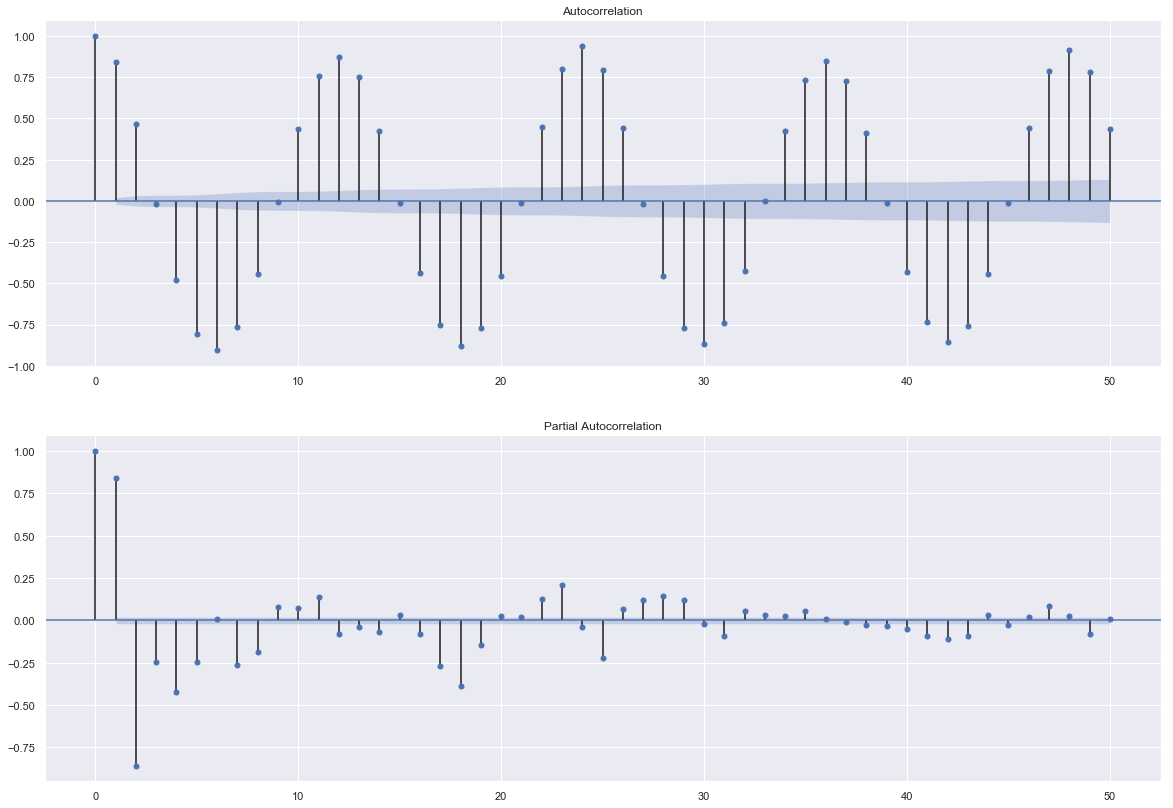



Computing ACF and PACF for 'F_PU1'


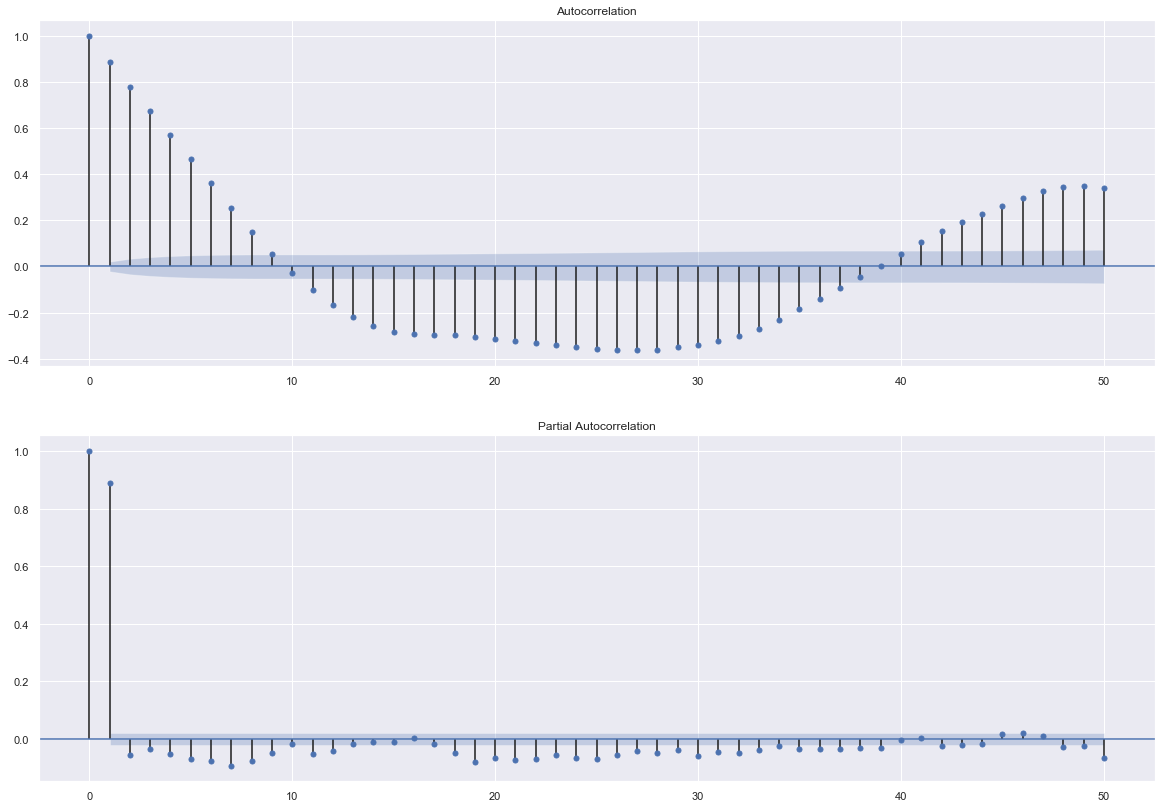



Computing ACF and PACF for 'L_T4'


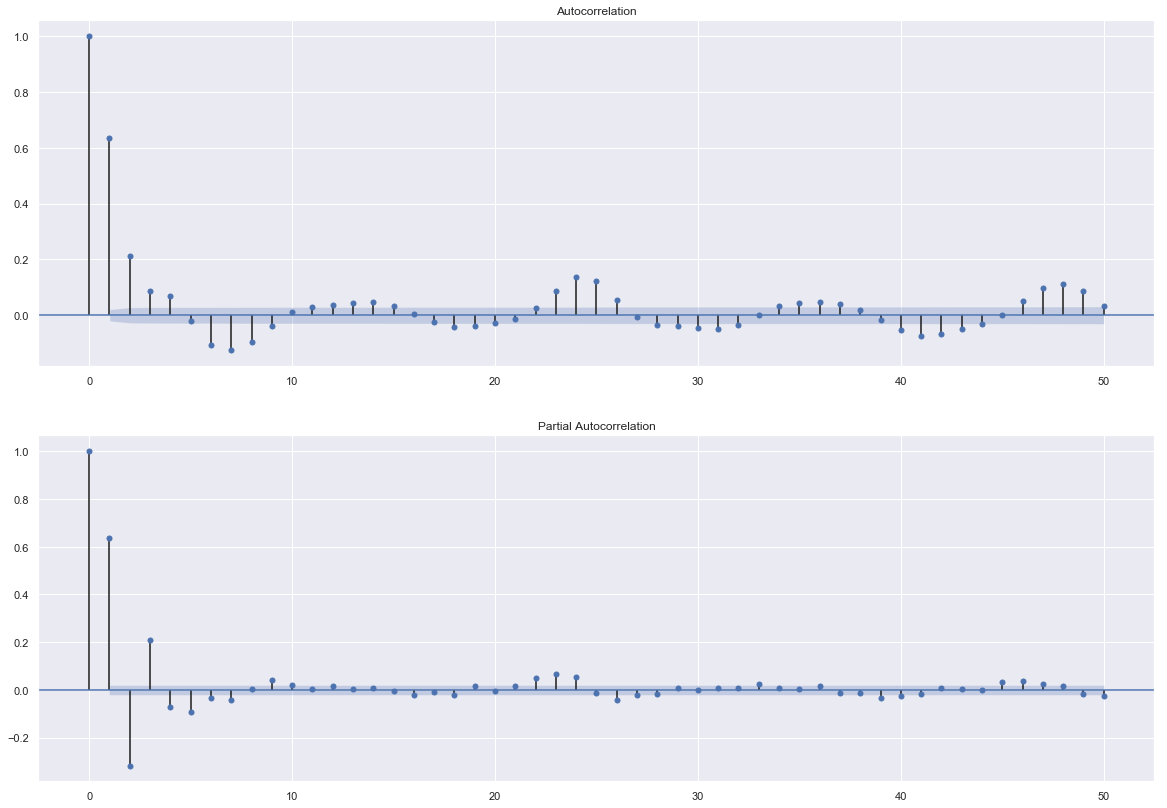



Computing ACF and PACF for 'F_PU10'


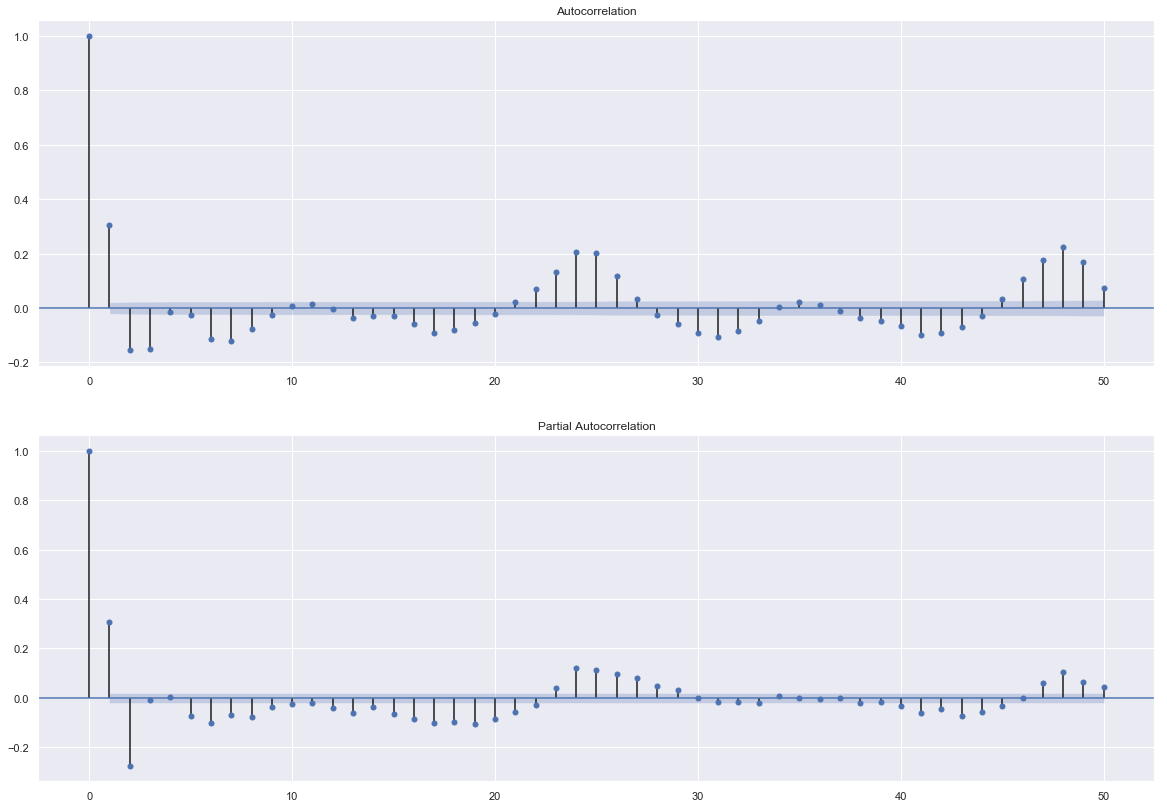

In [8]:
for signal in signals.keys():
    print(f"\n\nComputing ACF and PACF for '{signal}'")
    
    series = signals[signal]
    
    fig = plt.figure(figsize=(20,14))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(series, lags=50, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(series, lags=50, ax=ax2)
    plt.show()

By looking at the plot, we should choose the following orders for the signals:
    - p=11 and q=6 for L_T1
    - p=6 and q=13 for L_T2
    - p=3 and q=6 for L_T3
    - p=10 and q=10 for F_PU1
    - p=10 and q=13 for F_PU2
    - p=4 and q=3 for F_PU10

## Grid Search

In [9]:
import warnings
import pandas as pd
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [10]:
import warnings
# warnings.filterwarnings("ignore")

Now we can define a function for evaluating the different parameters for the ARMA model, based on either MSE or AIC. 

In [11]:
#resource: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/
def evaluate_arima_model_mse(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    error = np.mean(aics)
    return error

def evaluate_arima_model_aic(X, arima_order):
    model = ARIMA(X, order=arima_order)
    model_fit = model.fit(disp=0)
    return model_fit.aic

Now we define a method that loops over different sets of parameters for ARMA and evaluates the performance based on AIC.

In [12]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    #error = evaluate_arima_model_mse(dataset, order)
                    error = evaluate_arima_model_aic(dataset, order)
                    if error < best_score:
                        best_score, best_cfg = error, order
                    #print('ARIMA%s MSE=%.3f' % (order,error))
                    print('ARIMA%s AIC=%.3f' % (order,error))
                except:
                    continue # the try/catch is done because the optimization can fail: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/
    #print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    print('Best ARIMA%s AIC=%.3f' % (best_cfg, best_score))

We have to define a dictionary with values to test for the different signals.

In [13]:
#Format of the dictionary elements: Sjgnal_name:[p_list, d_list, q_list]
# this is based on what we found with using ACF and PACF
params = {'L_T1':[[8,9,10,11,12,13], [0], [3,4,5,6,7,8]],
         'L_T2': [[3,4,5,6,7,8], [0], [10,11,12,13,14,15]],
         'L_T3': [[1,2,3,4,5], [0], [3,4,5,6,7,8]],
         'F_PU1': [[7,8,9,10,11,12], [0], [7,8,9,10,11,12]],
         'L_T4': [[2,3,4,5,6,7], [0], [5,6,7,8,9,10]],
         'F_PU10': [[1,2,3,4,5,6], [0], [1,2,3,4,5]]}

In [14]:
# evaluate parameters
# warnings.filterwarnings("ignore")

# this TAKES A LOT, run it only if you really really really want to
# for signal in signals.keys():
#     print(f"\n\nComputing AIC values for '{signal}'")    
#     series = signals[signal]
#     p_values = params[signal][0]
#     d_values = params[signal][1]
#     q_values = params[signal][2]
#     evaluate_models(series.values, p_values, d_values, q_values)

Because of the way AIC works, it is likely to select a very complex model when testing too many models (). This is the case, where AIC suggests us to select the most complex model.    

If we look carefully to the values of AIC, though, we can see how there are some big drops. After this moment, the value of AIC goes down very slowly, suggesting that the added value of using a more complex parameter is not significant.   

We analyse for each signal where the drops happens, and we will use that order for the following steps

In [15]:
# values taken by grid search above
orders = {
    'L_T1': (11, 0, 6),
    'L_T2': (4, 0, 10),
    'L_T3': (2, 0, 4),
    'L_T4': (5, 0, 8),
    'F_PU1': (10, 0, 8),
    'F_PU10': (4, 0, 3),
}

In [16]:
# https://github.com/statsmodels/statsmodels/issues/2788 SARIMAX is needed to include new observations in time
def make_predictions_sarimax(trn_series, tst_series, order):
    mod_trn = sm.tsa.SARIMAX(trn_series, order=order, enforce_invertibility=False, enforce_stationarity=False)
    res_trn = mod_trn.fit(disp=0)
    
    predictions = []
    start_idx = tst_series.index[0]
    
    for tst_idx in tst_series.index:
        mod_tst = sm.tsa.SARIMAX(tst_series[start_idx:tst_idx], order=order)
        res_tst = mod_tst.filter(res_trn.params)
        output = res_tst.forecast(1)
        predictions.append(output.values)
        
    return predictions
    

We choose training set 1 to fit our ARMA. This is because there are no attacks in this training set --> we can learn the normal behaviour

Predicting and plotting prediction for 'L_T1'


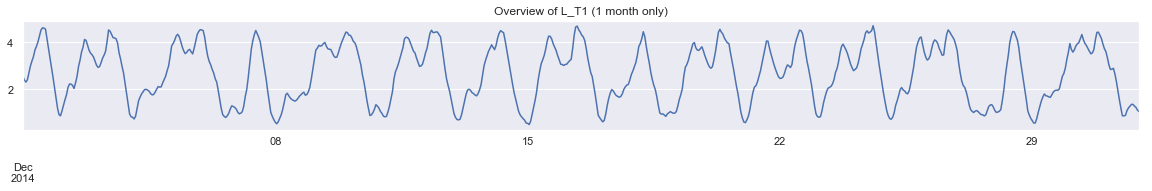

7753 hours used for training, 1008 for testing.


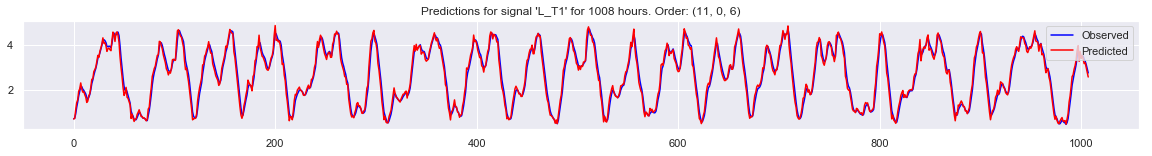

MSE: 0.04236925380274198
Predicting and plotting prediction for 'L_T2'


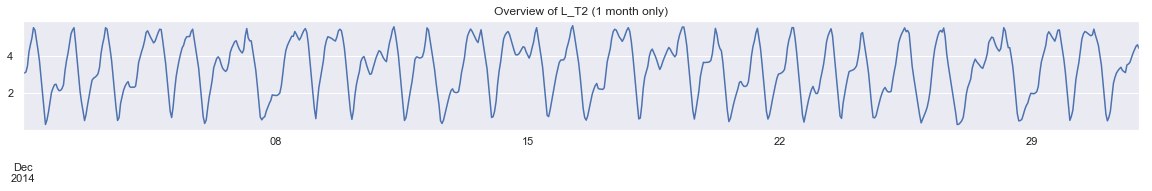

7753 hours used for training, 1008 for testing.


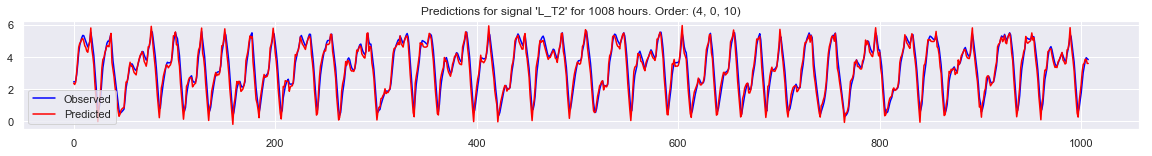

MSE: 0.1568486846408984
Predicting and plotting prediction for 'L_T3'


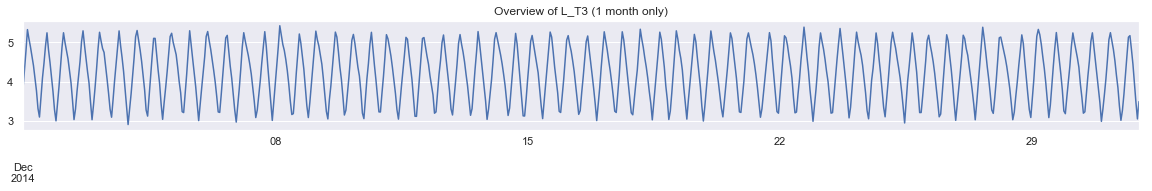

7753 hours used for training, 1008 for testing.


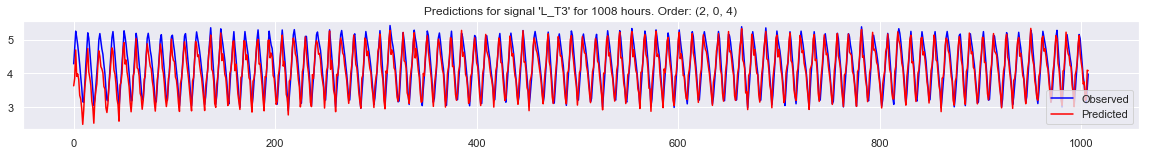

MSE: 0.08816099618237414
Predicting and plotting prediction for 'F_PU1'


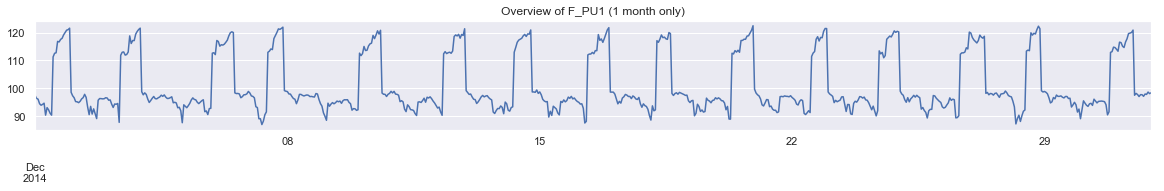

7753 hours used for training, 1008 for testing.


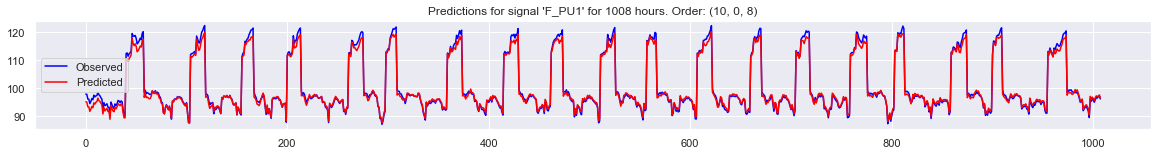

MSE: 1.1595836981176326
Predicting and plotting prediction for 'L_T4'


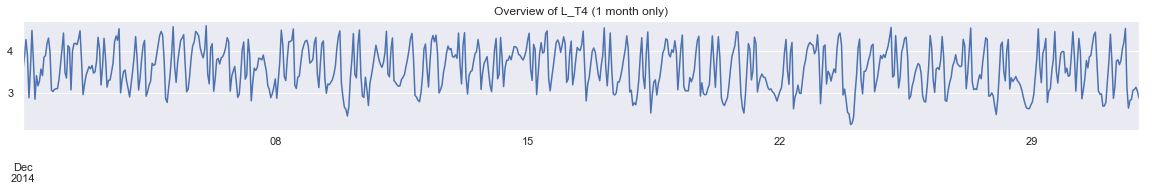

7753 hours used for training, 1008 for testing.


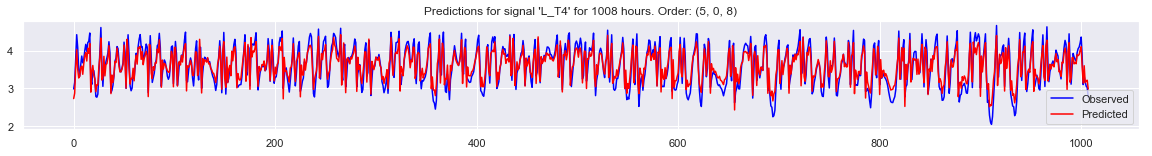

MSE: 0.05249914761448946
Predicting and plotting prediction for 'F_PU10'


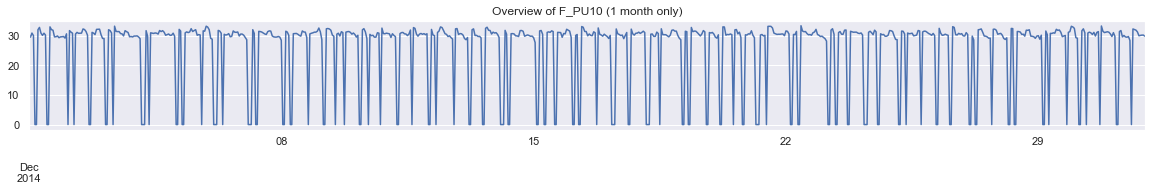

7753 hours used for training, 1008 for testing.


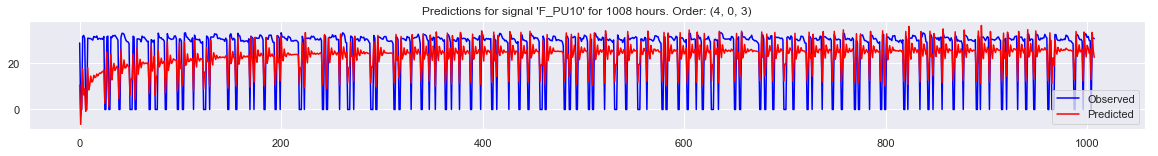

MSE: 82.14503467018037


In [17]:
for signal in signals.keys():
    print(f"Predicting and plotting prediction for '{signal}'")
    signal_data = signals[signal]
    #print("{} data points for signal '{}'".format(signal_data.shape[0], signal))
    #print(signal_data.head(5))
    
    signal_data.loc['2014-12'].plot(figsize=(20, 2), title=f"Overview of {signal} (1 month only)")
    plt.show()
    
    hours_to_predict = 24 * 7 * 6
    split_point = len(signal_data) - hours_to_predict 

    train = signal_data.iloc[0:split_point]
    test = signal_data.iloc[split_point:]
    print(f"{train.shape[0]} hours used for training, {test.shape[0]} for testing.")

    predictions = make_predictions_sarimax(train, test, orders[signal])

    plt.figure(figsize=(20,2))
    plt.plot(test.values, color='blue', label='Observed')
    plt.plot(predictions, color='red', label='Predicted')
    plt.title(f"Predictions for signal '{signal}' for {hours_to_predict} hours. Order: {orders[signal]}")
    plt.legend()
    plt.show()
    
    print(f"MSE: {mean_squared_error(test.values, predictions)}")

### Thresholding to find anomalies

In [18]:
file_name = "trn_set_2"
DATA_PATH = r"C:../data/{}.csv".format(file_name)

data_trn_2 = pd.read_csv(DATA_PATH, header=0, parse_dates=['DATETIME'], index_col='DATETIME', dayfirst=True)
data_trn_2.index = pd.DatetimeIndex(data_trn_2.index.values, freq = data_trn_2.index.inferred_freq)

Let's just look at an overview of the signals we are working with, in the second dataset (we also plot the attack labels)

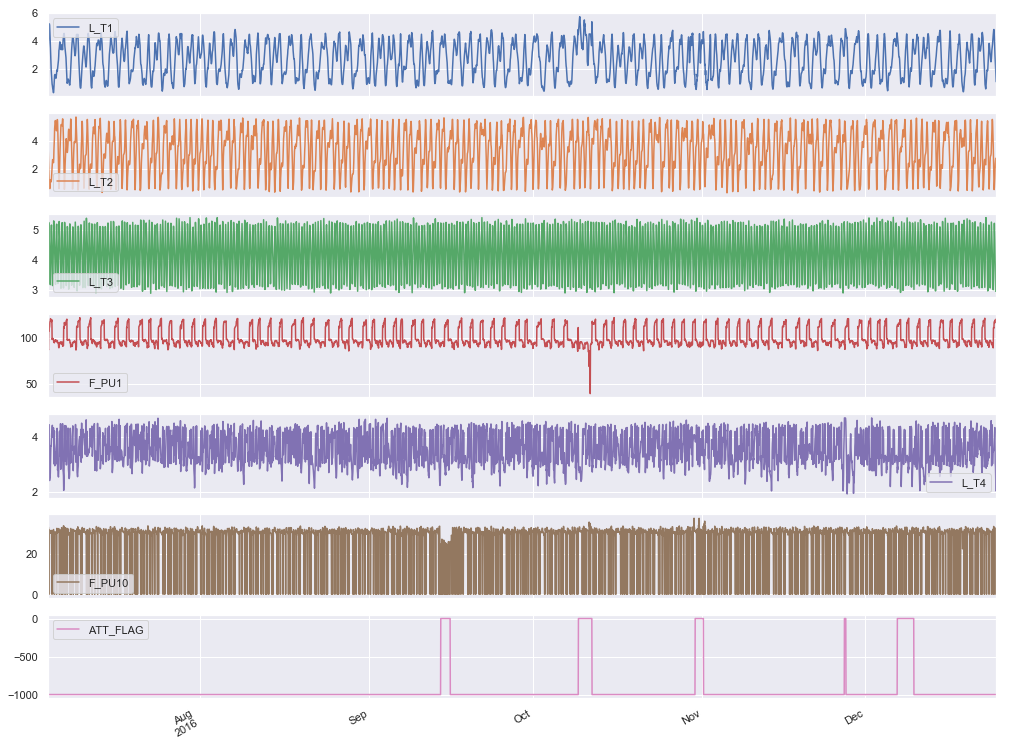

In [19]:
axes = data_trn_2[names + ['ATT_FLAG']].plot(figsize=(17, 2*(len(names)+1)), subplots=True) 
plt.show()

In [20]:
test_signals = {}

for name in names:
    series = pd.Series(data_trn_2[name], data_trn_2.index)
    test_signals[name] = series
    # display(series.head(2))



Processing signal 'L_T1'


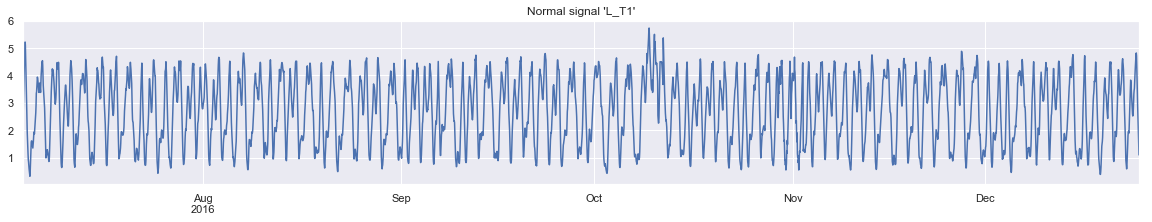



Processing signal 'L_T2'


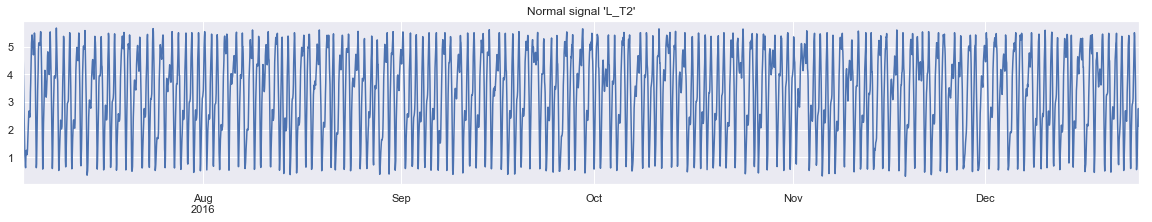



Processing signal 'L_T3'


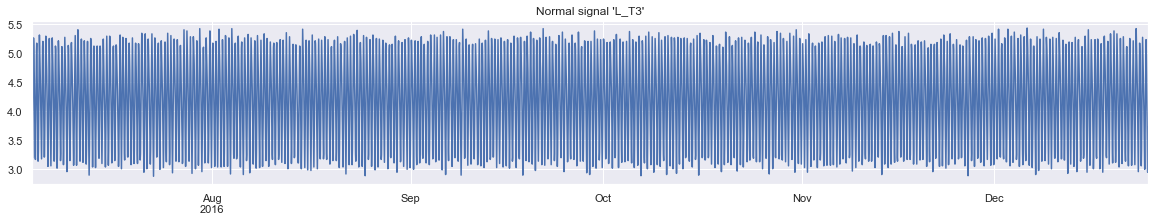



Processing signal 'F_PU1'


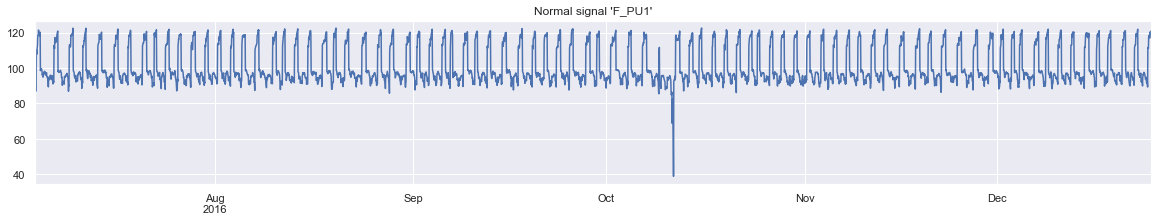



Processing signal 'L_T4'


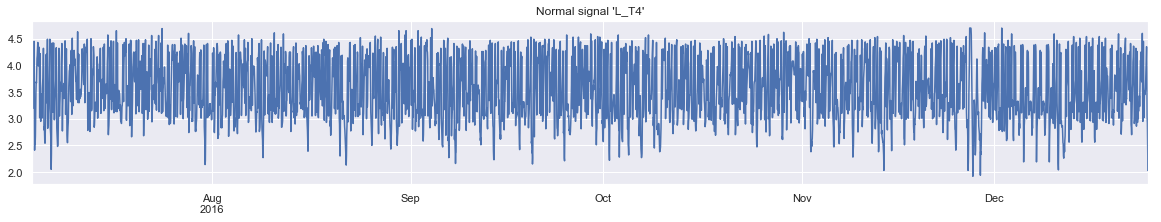



Processing signal 'F_PU10'


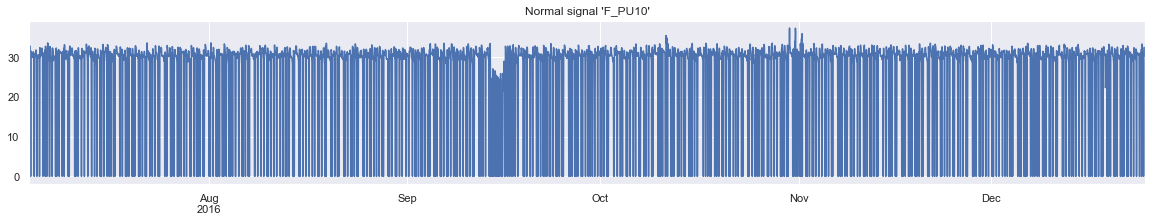

In [21]:
for test_signal in test_signals.keys():
    print(f"\n\nProcessing signal '{test_signal}'")
    
    test_series = test_signals[test_signal]
    
    # visualize it
    test_series.plot(figsize=(20,3))
    plt.title(f"Normal signal '{test_signal}'")
    plt.show()
    
    # do not uncomment. Differencing has been shown not necessary
    #test_stationary = difference(test_series)

    # visualize it
    #test_stationary.plot(figsize=(20,3))
    #plt.title(f"Stationary signal '{test_signal}'")
    #plt.show()
              
    #test_signals[test_signal] = test_stationary

## Detection!

In [22]:
def make_detection_sarimax(trn_series, tst_series, order):
    
    new_test = tst_series.copy()
    
    mod_trn = sm.tsa.SARIMAX(trn_series, order=order, enforce_invertibility=False, enforce_stationarity=False)
    res_trn = mod_trn.fit(disp=0)
    
    predictions = []
    residuals = []
    start_idx = new_test.index[0]
    for tst_idx in new_test.index:
        mod_tst = sm.tsa.SARIMAX(new_test[start_idx:tst_idx], order=order)
        res_tst = mod_tst.filter(res_trn.params)
        output = res_tst.forecast(1)
        predictions.append(output.values)
        residual = (output.values - new_test[tst_idx])**2
        residuals.append(residual)

    return pd.Series(predictions, new_test.index), pd.Series(residuals, new_test.index)

To tune the threshold for the residuals, we use the MSE obtained during training (on normal behaviour) and then we perform grid search on a range of multipliers.

In [23]:
# values obtained during training (dataset 1) on normal behaviour.
mean_squared_errors = {
    'L_T1': 0.0424,
    'L_T2': 0.1568,
    'L_T3': 0.0881,
    'F_PU1': 1.1596,
    'F_PU10': 82.145,
    'L_T4': 0.0525,
}

In [24]:
def get_conf_mat_entry(results, true_attack, pred_attack):
    # just a helper function to retrieve entries of the confusion matrix
    result = results[
        (results['true'] == (1 if true_attack else 0)) 
        & 
        (results['pred'] == (1 if pred_attack else 0))
    ]
    return result.shape[0]

## Gridsearch on threshold value, per signal.


------------------------------------

Predicting 'L_T1'
8761 hours used for training, 4177 for testing.
Displaying results


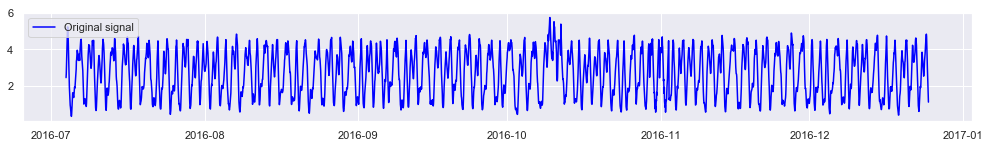

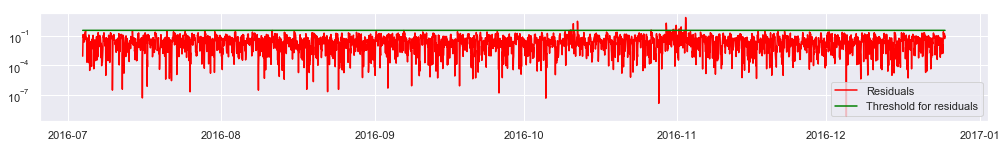

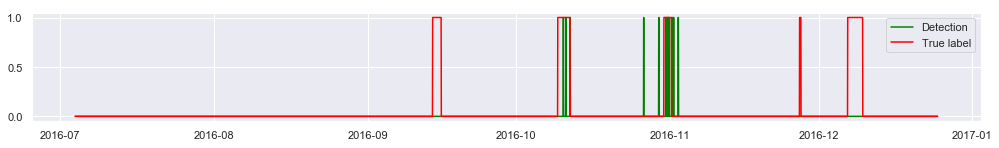

Best threshold for signal L_T1: 0.36151578947368423. F0.25: 0.2682445759368836
TP: 8. FP:10. TN:3948. FN: 211
Prec: 0.4444444444444444, Rec: 0.0365296803652968

------------------------------------

Predicting 'L_T2'
8761 hours used for training, 4177 for testing.
Displaying results


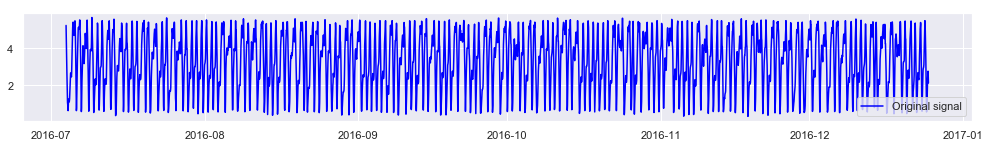

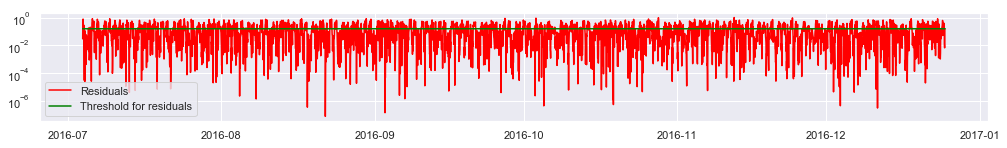

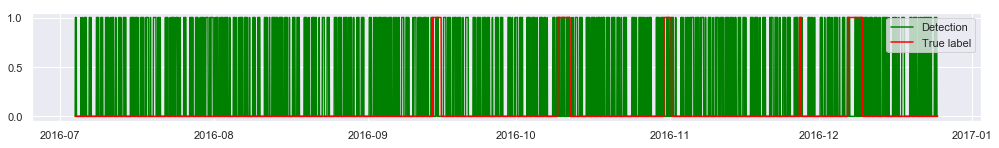

Best threshold for signal L_T2: 0.1568. F0.25: 0.058448915803867955
TP: 88. FP:1498. TN:2460. FN: 131
Prec: 0.05548549810844893, Rec: 0.4018264840182648

------------------------------------

Predicting 'L_T3'
8761 hours used for training, 4177 for testing.
Displaying results


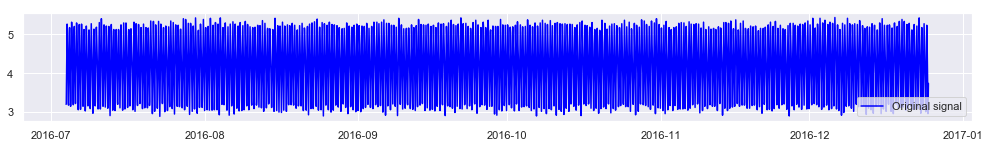

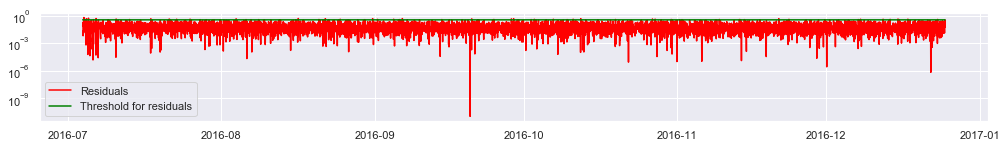

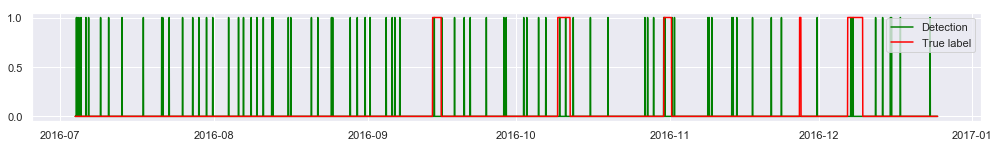

Best threshold for signal L_T3: 0.34312631578947367. F0.25: 0.0666231221423906
TP: 6. FP:76. TN:3882. FN: 213
Prec: 0.07317073170731707, Rec: 0.0273972602739726

------------------------------------

Predicting 'F_PU1'
8761 hours used for training, 4177 for testing.
Displaying results


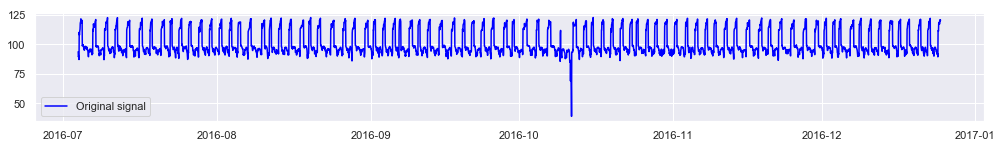

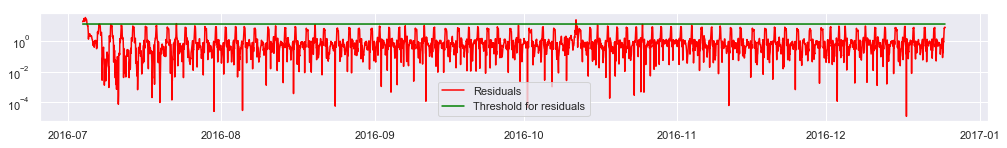

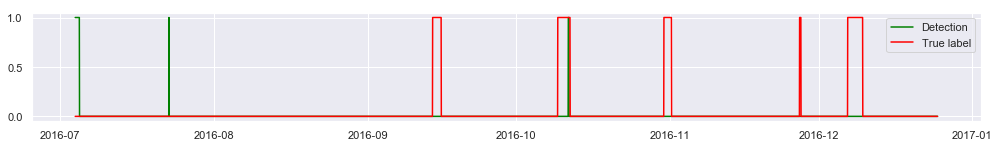

Best threshold for signal F_PU1: 13.243852631578948. F0.25: 0.08239095315024232
TP: 3. FP:22. TN:3936. FN: 216
Prec: 0.12, Rec: 0.0136986301369863

------------------------------------

Predicting 'L_T4'
8761 hours used for training, 4177 for testing.
Displaying results


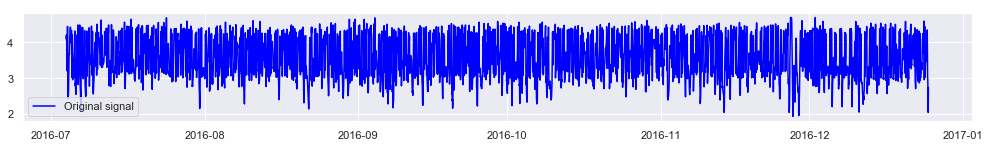

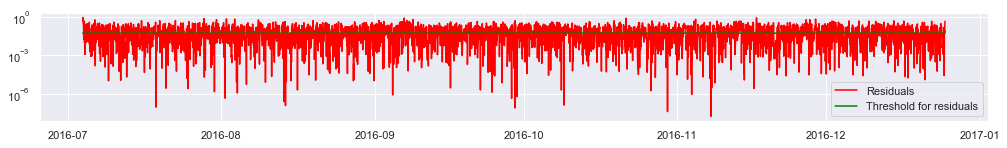

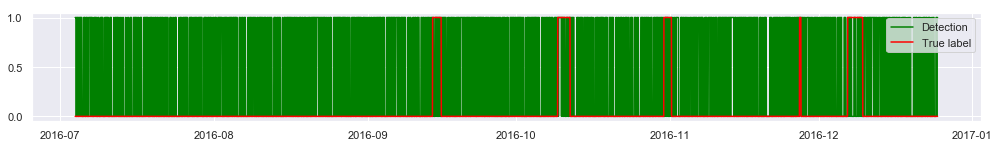

Best threshold for signal L_T4: 0.0525. F0.25: 0.05956887651346869
TP: 112. FP:1872. TN:2086. FN: 107
Prec: 0.056451612903225805, Rec: 0.5114155251141552

------------------------------------

Predicting 'F_PU10'
8761 hours used for training, 4177 for testing.
Displaying results


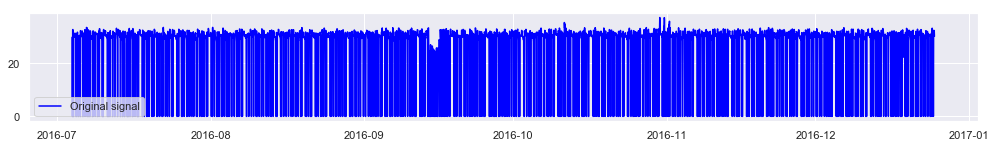

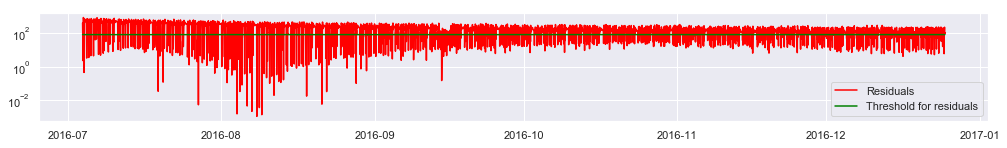

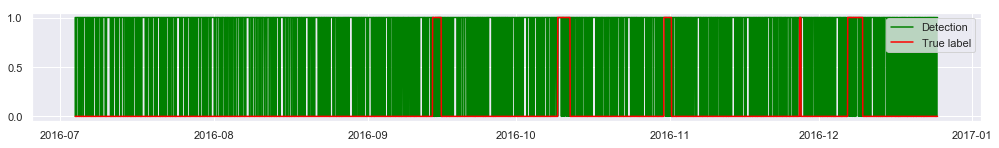

Best threshold for signal F_PU10: 82.145. F0.25: 0.05022734685263703
TP: 154. FP:3090. TN:868. FN: 65
Prec: 0.047472256473489516, Rec: 0.7031963470319634


In [28]:
thres_multipliers = np.linspace(1, 12, 20)
labels = data_trn_2['ATT_FLAG'].map({-999:0, 1:1})
beta = 0.25


for signal in signals.keys():
    fbeta_best = 0
    threshold_best = 0
    mult_best = 0
    best_t_p = 0
    best_f_p = 0
    best_t_n = 0
    best_f_n = 0
    best_prec = 0
    best_rec = 0
    best_detection = None
    
    print(f"\n------------------------------------\n\nPredicting '{signal}'")
    signal_data = signals[signal]
    test_signal = test_signals[signal]

    train = signal_data
    test = test_signal
    print(f"{train.shape[0]} hours used for training, {test.shape[0]} for testing.")

    predictions, residuals = make_detection_sarimax(train, test, orders[signal])
    
    for mult in thres_multipliers:
        threshold = mult * mean_squared_errors[signal]        
        
        detection = pd.DataFrame(np.zeros(test.size), test.index)
        detection[residuals>threshold] = 1
        
        res = pd.concat([labels[detection.index], detection], axis=1) # only take labels when predicted
        res.columns = ['true', 'pred']
        res.set_index(detection.index)
                
        t_p = get_conf_mat_entry(res, true_attack=True, pred_attack=True)
        t_n = get_conf_mat_entry(res, true_attack=False, pred_attack=False)
        f_p = get_conf_mat_entry(res, true_attack=False, pred_attack=True)
        f_n = get_conf_mat_entry(res, true_attack=True, pred_attack=False)

        try:
            precision = t_p/(t_p + f_p)
        except:
            continue
        
        try:
            recall = t_p/(t_p + f_n)                
        except:
            continue
            
        if (precision + recall ) == 0:
            continue

        
        fbeta = ( 1 + (beta**2)) * ( precision * recall ) / ((beta**2) * precision + recall )
                
        if fbeta > fbeta_best:
            # save all the parameters for the best fbeta score
            fbeta_best = fbeta
            threshold_best = threshold
            best_t_p = t_p
            best_f_p = f_p
            best_t_n = t_n
            best_f_n = f_n
            best_prec = precision
            best_rec = recall
            best_detection = detection
            mult_best = mult

    # per signal
    best_data = {
        'mult': mult_best,
        'threshold': threshold_best,
    }
    signals[signal]['best'] = best_data
    
    print("Displaying results")
    
    plt.figure(figsize=(17,2))
    plt.plot(data_trn_2[signal], color='blue', label='Original signal')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(17,2))
    plt.plot(residuals, color='red', label='Residuals')
    threshold_series = pd.DataFrame(np.array([threshold_best for i in range(residuals.shape[0])]), residuals.index)
    plt.plot(threshold_series, color='green', label='Threshold for residuals')
    plt.yscale("log")
    plt.legend()
    plt.show()

    plt.figure(figsize=(17,2))
    plt.plot(best_detection, color='green', label='Detection')
    plt.plot(labels, color='red', label='True label')
    plt.legend()
    plt.show()  
    print(f"Best threshold for signal {signal}: {threshold_best}. F{beta}: {fbeta_best}")
    print(f"TP: {best_t_p}. FP:{best_f_p}. TN:{best_t_n}. FN: {best_f_n}")
    print(f"Prec: {best_prec}, Rec: {best_rec}")


# Testing on test set

In [46]:
file_name = "test_set"
DATA_PATH = r"C:../data/{}.csv".format(file_name)

data_test = pd.read_csv(DATA_PATH, header=0, parse_dates=['DATETIME'], index_col='DATETIME', dayfirst=True).astype(float)
data_test.index = pd.DatetimeIndex(data_test.index.values, freq = data_test.index.inferred_freq)

# keep only signals for which we modeled ARMA
data_test = data_test[names]
data_test.head()

L_T1  L_T2  L_T3  F_PU1  L_T4  F_PU10
2017-01-04 00:00:00  0.73  2.27  4.00  98.93  3.26   29.37
2017-01-04 01:00:00  0.69  2.25  4.53  97.95  3.26   30.63
2017-01-04 02:00:00  0.90  2.31  5.03  96.82  3.41    0.00
2017-01-04 03:00:00  1.11  2.54  5.16  96.76  3.97   31.64
2017-01-04 04:00:00  1.27  2.99  4.94  94.77  4.27   31.92

L_T1
best threshold: 0.36151578947368423


------------------------------------
Detecting 'L_T1'


2014-01-06 00:00:00    0.50973
2014-01-06 01:00:00    0.41258
Name: L_T1, dtype: float64

2017-01-04 00:00:00    0.73
2017-01-04 01:00:00    0.69
Freq: H, Name: L_T1, dtype: float64

8761 hours used for training, 2089 for testing.


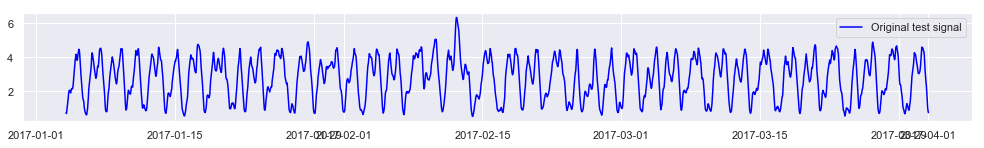

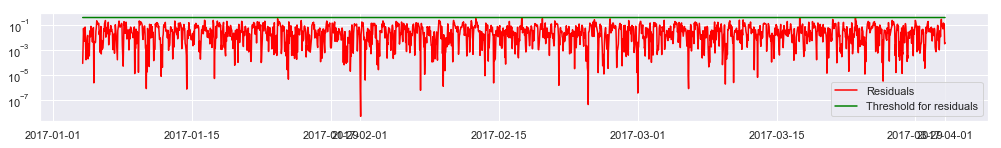

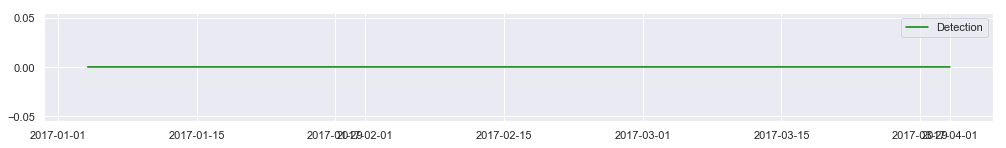

L_T2
best threshold: 0.1568


------------------------------------
Detecting 'L_T2'


2014-01-06 00:00:00    2.049003
2014-01-06 01:00:00    2.009072
Name: L_T2, dtype: float64

2017-01-04 00:00:00    2.27
2017-01-04 01:00:00    2.25
Freq: H, Name: L_T2, dtype: float64

8761 hours used for training, 2089 for testing.


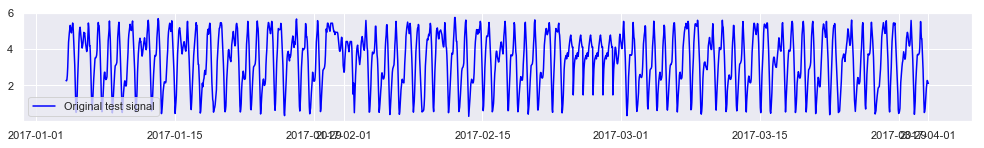

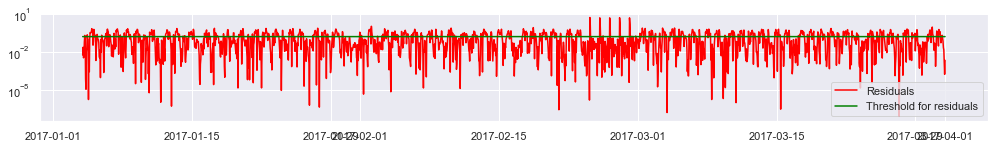

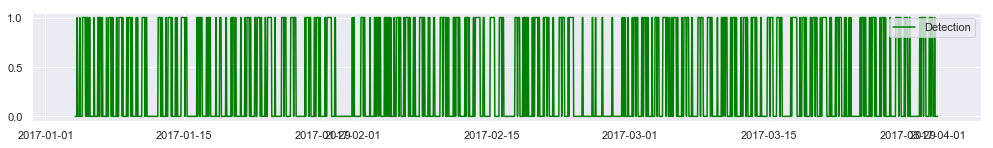

L_T3
best threshold: 0.34312631578947367


------------------------------------
Detecting 'L_T3'


2014-01-06 00:00:00    3.191145
2014-01-06 01:00:00    3.642565
Name: L_T3, dtype: float64

2017-01-04 00:00:00    4.00
2017-01-04 01:00:00    4.53
Freq: H, Name: L_T3, dtype: float64

8761 hours used for training, 2089 for testing.


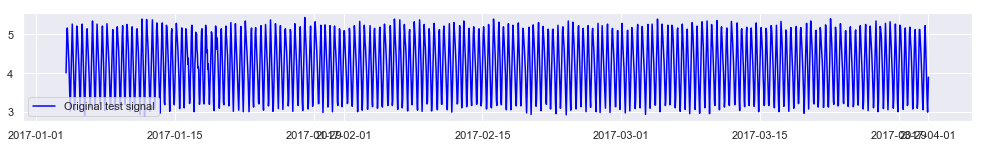

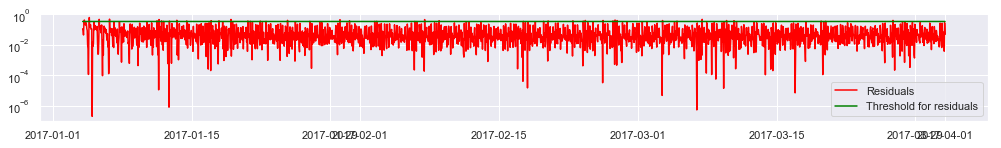

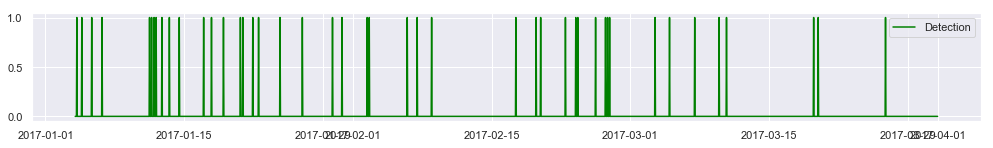

F_PU1
best threshold: 13.243852631578948


------------------------------------
Detecting 'F_PU1'


2014-01-06 00:00:00    98.998444
2014-01-06 01:00:00    99.095901
Name: F_PU1, dtype: float64

2017-01-04 00:00:00    98.93
2017-01-04 01:00:00    97.95
Freq: H, Name: F_PU1, dtype: float64

8761 hours used for training, 2089 for testing.


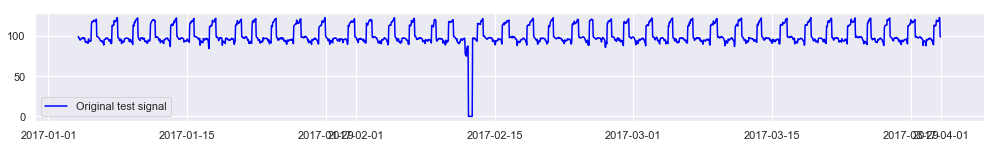

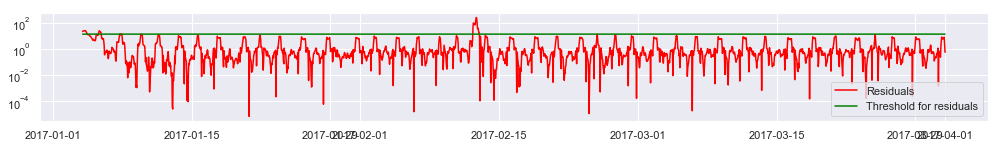

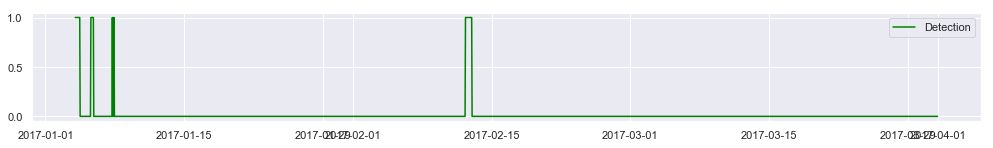

L_T4
best threshold: 0.0525


------------------------------------
Detecting 'L_T4'


2014-01-06 00:00:00    2.792634
2014-01-06 01:00:00    2.831673
Name: L_T4, dtype: float64

2017-01-04 00:00:00    3.26
2017-01-04 01:00:00    3.26
Freq: H, Name: L_T4, dtype: float64

8761 hours used for training, 2089 for testing.


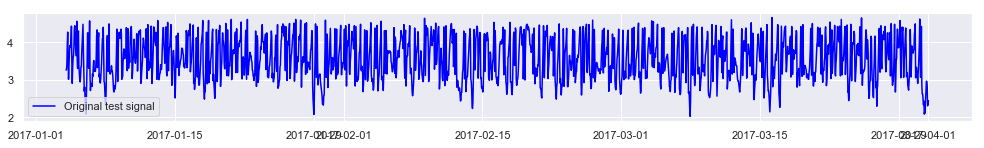

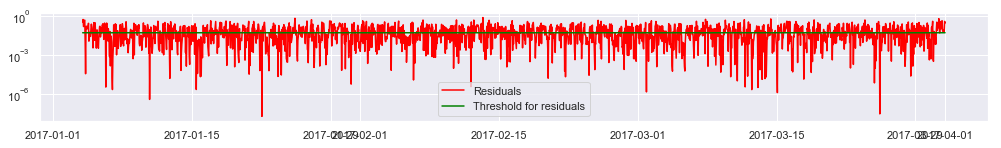

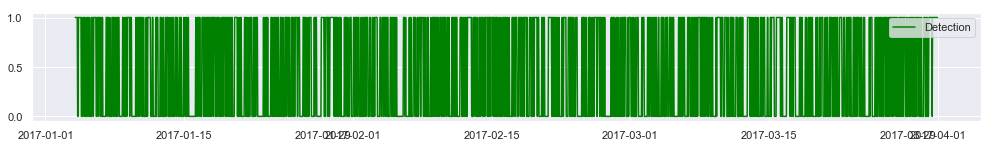

F_PU10
best threshold: 82.145


------------------------------------
Detecting 'F_PU10'


2014-01-06 00:00:00    30.512712
2014-01-06 01:00:00    30.480455
Name: F_PU10, dtype: float64

2017-01-04 00:00:00    29.37
2017-01-04 01:00:00    30.63
Freq: H, Name: F_PU10, dtype: float64

8761 hours used for training, 2089 for testing.


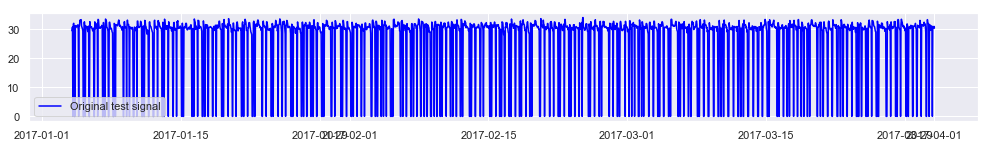

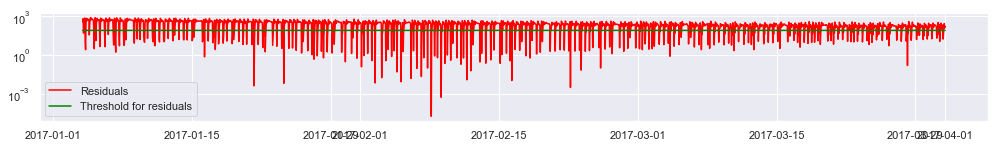

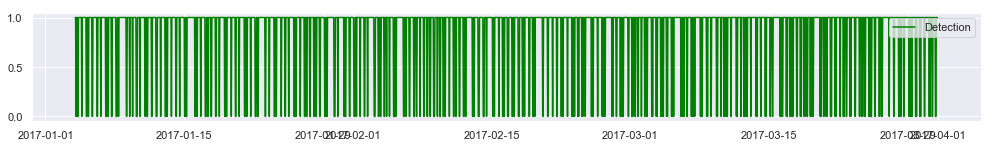

In [53]:
for signal in signals.keys():
    print(signal)
    print(f"best threshold: {signals[signal]['best']['threshold']}")
    
    threshold = signals[signal]['best']['threshold'] # threshold tuned on training data 2
    
    print(f"\n\n------------------------------------\nDetecting '{signal}'")
    train_data = signals[signal][:-1].astype(float)
    test_data = pd.Series(data_test[signal], data_test.index)
          
    display(train_data.head(2))
    display(test_data.head(2))

    print(f"{train_data.shape[0]} hours used for training, {test_data.shape[0]} for testing.")
          
    predictions, residuals = make_detection_sarimax(train_data, test_data, orders[signal])

    detection = pd.DataFrame(np.zeros(test_data.size), test_data.index)
    detection[residuals>threshold] = 1
          
    plt.figure(figsize=(17,2))
    plt.plot(data_test[signal], color='blue', label='Original test signal')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(17,2))
    plt.plot(residuals, color='red', label='Residuals')
    threshold_series = pd.DataFrame(np.array([threshold for i in range(residuals.shape[0])]), residuals.index)
    plt.plot(threshold_series, color='green', label='Threshold for residuals')
    plt.yscale("log")
    plt.legend()
    plt.show()

    plt.figure(figsize=(17,2))
    plt.plot(detection, color='green', label='Detection')
    plt.legend()
    plt.show()  

## Discussion on this result

Some anomalies, such as the one shown for signal 'F_PU1', are well-detected with using ARMA modeling of the signal. This can be shown in the corresponding above plot. As far as this anomaly is concerned, this can be seen as both **behavioural** and **point** anomaly. In fact, ARMA are good at detecting these types of anomalies: by finding the orders through ACF and PACF plots, we have an ARMA model which is behaving like the original normal signal (training set 1). Whenever the behaviour of the observed signal is too different from the normal one (such as a sudden drop, or a constant value which lasts too long), then the residual of the prediction through the ARMA model becomes high, as we can see in the 'F_PU1' plot above. 

Some other anomalies, such as the ones in 'L_T1' are not detected at all. However, a closer look to the plot of the residuals reveals that it is just a matter of the threshold value: the residuals actually are higher when the anomaly happens, but the threshold (set by using gridsearch on training set 2) is too high to detect it.

In conclusion, we believe ARMA have a satisfying capability of detecting these anomalies. **We believe the reason behing having too high thresholds is due to the fact that the labels we have are wrong**: on the BATADAL website they explain how the data is partially labeled, and some of the attacks are completely missing. For this reason, when doing grid search to set the threshold, attacks which are detected by the model are seen as FALSE POSITIVES (only because they are not correcly labeled in the dataset). Therefore, the Fbeta score goes down and the threshold is brought up.